650 1.0 0.0


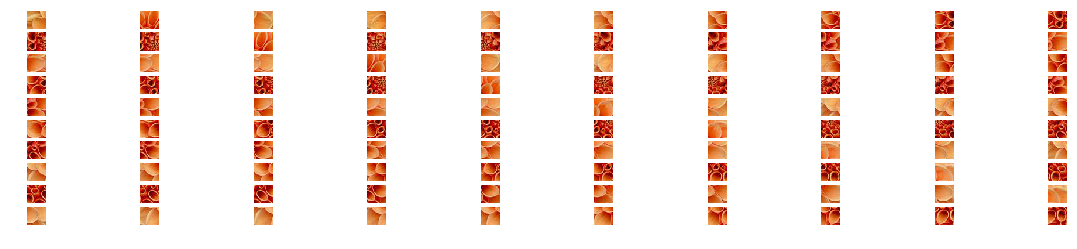

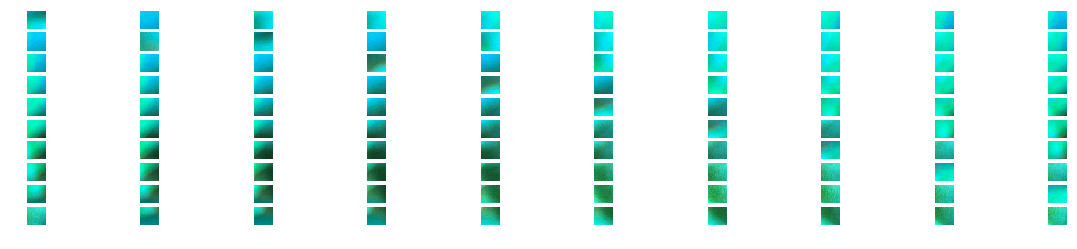

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path, time

# read positive and negative training images

Images = np.zeros((650,32,32,3),dtype=np.float32)
Labels = np.zeros((650,2),dtype=np.float32)
cnt=0
folder = "Positive"
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        im = np.array(Image.open(os.path.join(folder,file)))/255.0
        Images[cnt,:,:,:] = im
        Labels[cnt,0] = 1
        cnt = cnt + 1
folder = "Negative"
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        im = np.array(Image.open(os.path.join(folder,file)))/255.0
        Images[cnt,:,:,:] = im
        Labels[cnt,1] = 1
        cnt = cnt + 1
print(cnt,np.amax(Images),np.amin(Images))
%matplotlib inline
plt.figure(figsize=(20,40))
for iteration in range(100):
    plt.subplot(100, 10, iteration + 1)
    plt.imshow(Images[iteration,:,:,:])
    plt.axis("off")
plt.figure(figsize=(20,40))
for iteration in range(400,500,1):
    plt.subplot(100, 10, iteration + 1)
    plt.imshow(Images[iteration,:,:,:])
    plt.axis("off")

In [2]:
X = tf.placeholder(tf.float32,shape=(None,None,None,3),name="X")
#X = tf.placeholder(tf.float32,shape=(None,32,32,3),name="X")
y = tf.placeholder(tf.float32,shape=(None,2),name="y")

with tf.name_scope("dnn"):
    # conv layer 1
    conv1 = tf.layers.conv2d(inputs=X,filters=2,
                         kernel_size=[5, 5],padding="valid",activation=tf.nn.elu)
    print("conv1",conv1.shape)
    
    # maxpool layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print("pool1",pool1.shape)
    
    # Convolutional Layer #2 
    conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=[5, 5],
                          padding="valid",activation=tf.nn.elu)
    print("conv2",conv2.shape)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print("pool2",pool2.shape)

    # Dense logits layer
    #logits = tf.layers.dense(inputs=tf.contrib.layers.flatten(pool2), units=2, 
                            #activation=tf.nn.relu)
    
    conv_logits = tf.layers.conv2d(inputs=pool2,filters=2,kernel_size=[5, 5],
                          padding="valid",activation=tf.nn.elu)
    print("conv_logits",conv_logits.shape)
    
    flattened_logits = tf.contrib.layers.flatten(conv_logits)
    print("flattened_logits",flattened_logits.shape)
    
with tf.name_scope("probability_and_loss"):
    yp    = tf.nn.softmax(conv_logits)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=flattened_logits)
    print("predticted y",yp.shape)

conv1 (?, ?, ?, 2)
pool1 (?, ?, ?, 2)
conv2 (?, ?, ?, 4)
pool2 (?, ?, ?, 4)
conv_logits (?, ?, ?, 2)
flattened_logits (?, ?)
predticted y (?, ?, ?, 2)


In [3]:
# Now train the convnet for classifying images
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    accuracy = 100.0*tf.reduce_mean(tf.cast(tf.equal(tf.argmax(flattened_logits,axis=1),tf.argmax(y,axis=1)),tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={X:Images, y:Labels})
        acc_train       = accuracy.eval(feed_dict={X:Images, y:Labels})
        print(epoch,"Training accuracy:",acc_train)
    save_path = saver.save(sess,"./my_model_final.ckpt")

0 Training accuracy: 99.6923
1 Training accuracy: 100.0
2 Training accuracy: 100.0
3 Training accuracy: 100.0
4 Training accuracy: 100.0
5 Training accuracy: 100.0
6 Training accuracy: 100.0
7 Training accuracy: 100.0
8 Training accuracy: 100.0
9 Training accuracy: 100.0


INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Training accuracy: 100.0
flower image shape (427, 640, 3)
segmented image shape (1, 99, 153, 2)


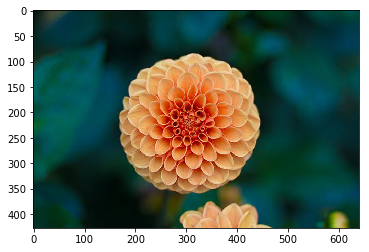

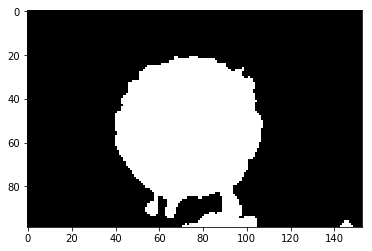

In [4]:
flower = np.array(Image.open("flower.jpg"))/255.0
h,w,c = flower.shape
im = np.zeros((1,h,w,c),dtype=np.float32)
im[0,:,:,:] = flower

# Restore model
with tf.Session() as sess:
    saver.restore(sess,"./my_model_final.ckpt")
    acc_train       = accuracy.eval(feed_dict={X:Images, y:Labels})
    print("Training accuracy:",acc_train)
    binary_seg = yp.eval(feed_dict={X:im})

print("flower image shape",flower.shape)
print("segmented image shape",binary_seg.shape)
plt.imshow(flower)
plt.show()
plt.imshow(binary_seg[0,:,:,0]>=0.5,cmap="gray")
plt.show()